這個實驗目標是測試不同策略搭配前面找到負相關的因子並持有第一群，看是否會提升收益
- 負相關因子 : ev_s、roe、pb、ps
- 策略逆勢布林通道、逢低買進、逆勢高低通道、順勢布林通道

In [1]:
from iplab.database import Database
from iplab.get_data import Data
from iplab import backtest
from iplab.combinations import sim_conditions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
data=Data()

(2003, "Can't connect to MySQL server on '140.115.82.199' (timed out)")
無法連結資料庫
'OperationalError' object has no attribute 'cursor'
無法執行SQL語法


TypeError: 'AttributeError' object is not subscriptable

In [ ]:
# 取得各因子的第一群
factor_dict = {
    'ev_s': data.get('report:ev_s').divide_slice(quantile=10, ascending = True)['Quantile_1'], # 小到大
    'roe': data.get('report:roe').divide_slice(quantile=10, ascending = False)['Quantile_1'], # 大到小
    'pb': data.get('report:pb').divide_slice(quantile=10, ascending = True)['Quantile_1'], # 小到大
    'ps': data.get('report:ps').divide_slice(quantile=10, ascending = True)['Quantile_1'], # 小到大
    'p_ic': data.get('report:p_ic').divide_slice(quantile=10, ascending = True)['Quantile_1'], # 大到小 -> 小到大
}

In [ ]:
# 先拿十年的回測
factor_dict_decade = { factor: factor_dict[factor].loc['2013-01-01':] for factor in factor_dict }

In [ ]:
single_factor_report_collection = sim_conditions(conditions=factor_dict, resample='M', data=data, combination=False)
single_factor_stats = single_factor_report_collection.stats.T.reset_index(names=['factor'])
single_factor_stats

# 分產業

In [ ]:
sector_list = pd.read_csv('../Data/taiwan_sector_list.csv', encoding='utf-8')
sector_list['industry_name'].unique()

array(['水泥工業', '食品工業', '農業科技', '觀光餐旅', '塑膠工業', '建材營造', '汽車工業', '電子零組件',
       '其他', '紡織纖維', '運動休閒', '電機機械', '生技醫療', '電腦及週邊', '電器電纜', '化學工業',
       '其他電子業', '玻璃陶瓷', '造紙工業', '鋼鐵工業', '居家生活', '橡膠工業', '航運業', '半導體',
       '通信網路業', '光電業', '電子通路業', '資訊服務業', '貿易百貨', '油電燃氣業', '數位雲端', '金融業',
       '文化創意業', '綠能環保', '存託憑證'], dtype=object)

In [ ]:
import itertools

target_sector = ['半導體', "建材營造", "金融業", "居家生活"]

# Generate all non-empty combinations of the target sectors
all_combinations = []
for r in range(1, len(target_sector) + 1):
    for combo in itertools.combinations(target_sector, r):
        all_combinations.append(list(combo))
all_combinations

[['半導體'],
 ['建材營造'],
 ['金融業'],
 ['居家生活'],
 ['半導體', '建材營造'],
 ['半導體', '金融業'],
 ['半導體', '居家生活'],
 ['建材營造', '金融業'],
 ['建材營造', '居家生活'],
 ['金融業', '居家生活'],
 ['半導體', '建材營造', '金融業'],
 ['半導體', '建材營造', '居家生活'],
 ['半導體', '金融業', '居家生活'],
 ['建材營造', '金融業', '居家生活'],
 ['半導體', '建材營造', '金融業', '居家生活']]

In [ ]:
combination_company_ids = {}
for combo in all_combinations[:4]:
    filtered_df = sector_list.loc[sector_list['industry_name'].isin(combo)]
    company_ids = [str(id) for id in list(filtered_df['company_id'])]
    combination_company_ids[tuple(combo)] = company_ids

In [ ]:
target_sector_dict = {
    "ev_s":data.get('report:ev_s'),
    "roe":data.get('report:roe'),
    "pb":data.get('report:pb'),
    "ps":data.get('report:ps'),
    "p_ic":data.get('report:p_ic'),
}

# target_sector_dict = { factor: target_sector_dict[factor].loc['2013-01-01':] for factor in target_sector_dict }

results_dict = {}

# Iterate over each combination and its company IDs
for combo, company_ids in combination_company_ids.items():
    # Convert the tuple of sectors into a string key
    combo_key = '&'.join(combo)

    # Retrieve common IDs for the current combination
    common_ids = target_sector_dict["ev_s"].columns.intersection(company_ids)

    # Apply data operations for each factor
    for factor in target_sector_dict:
        if factor == 'roe':
            # Sort 'roe' descending
            sorted_data = target_sector_dict[factor][common_ids].divide_slice(quantile=10, ascending=False)['Quantile_1']
        else:
            # Sort other factors ascending
            sorted_data = target_sector_dict[factor][common_ids].divide_slice(quantile=10, ascending=True)['Quantile_1']

        # Store the result in the dictionary
        result_key = f"{combo_key}&{factor}"
        results_dict[result_key] = sorted_data

In [ ]:
sector_report_collection = sim_conditions(conditions=results_dict, resample='M', data=data, combination=False)
sector_stats = sector_report_collection.stats.T.reset_index(names=['factor'])
# sector_stats

Backtesting progress:   0%|          | 0/20 [00:00<?, ?condition/s]

Backtesting progress: 100%|██████████| 20/20 [00:04<00:00,  4.52condition/s]


In [ ]:
sector_top_5_df = sector_stats.sort_values(by=['CAGR'], ascending=False).head(10)
sector_top_5_df

,factor,CAGR,daily_sharpe,max_drawdown,avg_drawdown,win_ratio,ytd
19,居家生活&p_ic,0.398071,17.21,-0.764846,-0.271151,0.750000,0.024108
7,建材營造&pb,0.324120,17.24,-0.605836,-0.069699,0.777778,0.060244
15,居家生活&ev_s,0.281684,16.19,-0.623329,-0.210362,0.611111,0.069505
9,建材營造&p_ic,0.281346,17.47,-0.612490,-0.096508,0.666667,0.063303
2,半導體&pb,0.273645,12.61,-0.725041,-0.139544,0.694656,0.220003
18,居家生活&ps,0.251922,15.95,-0.793088,-0.241476,0.595238,0.020593
8,建材營造&ps,0.228397,22.13,-0.556686,-0.093540,0.578035,0.154106
4,半導體&p_ic,0.220133,13.50,-0.753188,-0.164142,0.544304,0.224972
16,居家生活&roe,0.211845,15.99,-0.606815,-0.153391,0.490566,0.141084
3,半導體&ps,0.193997,16.22,-0.687458,-0.150661,0.418440,0.262743


# 測試hold_until和AND運算

In [ ]:
a=data.indicator('BBANDS', resample='D', nbdevup=float(1.5), nbdevdn=float(1.5), timeperiod=120)
close=data.get('price:close')

In [ ]:
entries = close < a[2]
# 0:upperband
exits = close > a[0]
strategy = entries.hold_until(exits)

In [ ]:
from iplab.dataframe import CustomDataFrame
test_factor = CustomDataFrame(index=factor_dict['roe'].index[0:2], columns=factor_dict['roe'].columns[0:1], data=[True, False])
test_factor

In [ ]:
test_strategy = CustomDataFrame(
    index=strategy.index[90:200],
    columns=strategy.columns[0:1],
    data=[False]*20 + [True]*90
)
test_strategy.head(25)

In [ ]:
(test_factor & test_strategy).tail(30)

# 繪製圖的function
1. 標準差橢圓
2. KDE


In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Ellipse
from matplotlib.ticker import FuncFormatter
import pandas as pd

def draw_strategy_scatter(df, benchmark_df):
    def percent_formatter(x, pos):
        return f'{x*100:.0f}%'

    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 8))
    markers = ['o', 's', 'D', '^', '<', '>', 'v', 'p', 'P']  # 考慮增加更多的標記以處理更多的策略

    scatter_plot = sns.scatterplot(x='max_drawdown', y='CAGR', hue='strategy', style='strategy', markers=markers, s=100, data=df, palette='tab10')
    plt.scatter(benchmark_df['max_drawdown'], benchmark_df['CAGR'], color='red', marker='o', s=100)


    scatter_plot.xaxis.set_major_formatter(FuncFormatter(percent_formatter))
    scatter_plot.yaxis.set_major_formatter(FuncFormatter(percent_formatter))

    ax = plt.gca()
    handles, labels = scatter_plot.get_legend_handles_labels()

    # 創建一個包含每個策略的額外圖例條目的列表
    extra_legend_items = []
    for idx, strategy in enumerate(df['strategy'].unique()):
        strategy_data = df[df['strategy'] == strategy]
        ellipse = Ellipse(
            xy=(strategy_data['max_drawdown'].mean(), strategy_data['CAGR'].mean()),
            width=strategy_data['max_drawdown'].std() * 2,
            height=strategy_data['CAGR'].std() * 2,
            edgecolor=handles[idx].get_edgecolor(),
            facecolor='none',
            linewidth=3
        )
        ax.add_patch(ellipse)

        cagr_mean_percent = strategy_data["CAGR"].mean() * 100
        mdd_mean_percent = strategy_data["max_drawdown"].mean() * 100
        extra_legend_items.append(f'{strategy}, CAGR={cagr_mean_percent:.3f}%, MDD={mdd_mean_percent:.3f}%')

    # 更新圖例
    scatter_plot.legend(handles=handles, labels=extra_legend_items, title='Strategy', loc='upper left', bbox_to_anchor=(1, 1))

    plt.title("Scatter")
    plt.xlabel("MDD[%]")
    plt.ylabel("CAGR[%]")
    plt.show()

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

def draw_strategy_kde(df):
    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 8))

    for idx, strategy in enumerate(df['strategy'].unique()):
        strategy_data = df[df['strategy'] == strategy]
        cagr_mean_percent = strategy_data["CAGR"].mean() * 100
        label= f'{strategy}, CAGR={cagr_mean_percent:.3f}%'
        sns.kdeplot(data=strategy_data, x='CAGR', label=label)

    plt.legend( title='Strategy', loc='upper left', bbox_to_anchor=(1, 1))
    plt.title("KDE")
    plt.xlabel("CAGR[%]")
    plt.ylabel("Density")
    plt.show()

# 逆勢布林通道
當收盤價跌破下軌線觸發進場條件，當收盤價突破上軌線觸發出場條件，可設定的參數為移動平均線及上下軌標準差。
1. 移動平均線 : 120、200、240日
2. 標準差 : 1.5、2、2.5倍標準差

In [ ]:
close=data.get('price:close')

# 布林通道縮寫:bband
# 逆勢用n代表
n_bband={}

for ma in [120, 150, 180, 210, 240]: # 移動平均線
    for dev in [1.5, 1.8, 2.1, 2.4,2.7]: # 標準差
        n_bband[f'MA_{ma}_std_{dev}'.replace('.', '_')] = data.indicator('BBANDS', resample='D', nbdevup=float(dev), nbdevdn=float(dev), timeperiod=ma)

In [ ]:
n_bband_conditions = {}
for sector in sector_top_5_df['factor']:
    for k,v in n_bband.items():
        # 2:lowerband
        entries = close < v[2]
        # 0:upperband
        exits = close > v[0]
        strategy = entries.hold_until(exits)
        n_bband_conditions[f'{k}&{sector}'] = strategy & results_dict[str(sector)]

In [ ]:
n_bband_conditions = {}
for factor in factor_dict.keys():
    for k,v in n_bband.items():
        # 2:lowerband
        entries = close < v[2]
        # 0:upperband
        exits = close > v[0]
        strategy = entries.hold_until(exits)
        # n_bband_conditions[f'{k}&{factor}'] = strategy & factor_dict[str(factor)]
        n_bband_conditions[f'{k}&{factor}'] = strategy & target_sector_dict[str(factor)]
        # n_bband_conditions[f'{k}&{factor}'] = strategy.loc['2013-01-01':] & factor_dict_decade[str(factor)]
        # n_bband_conditions[f'{k}'] = strategy

In [ ]:
n_bband_report_collection = sim_conditions(conditions=n_bband_conditions, resample='M', data=data, combination=False)
n_bband_df = n_bband_report_collection.stats.T
n_bband_df.index = n_bband_df.index.str.split('&', n=1, expand=True)
n_bband_df = n_bband_df.reset_index(names=['strategy', 'factor'])
split_columns = n_bband_df['strategy'].str.split('_', expand=True)
n_bband_df['MA'] = split_columns[1].astype(int)
n_bband_df['std'] = split_columns[3].astype(int) + (split_columns[4].astype(int)/10)

In [ ]:
n_bband_df.to_csv('../Data/factor_strategy_result/n_bband_df.csv', encoding='utf-8-sig')

In [ ]:
n_bband_df.sort_values(by=['CAGR'], ascending=False).head(10)

In [ ]:
draw_strategy_scatter(n_bband_df, sector_top_5_df)

In [ ]:
draw_strategy_kde(n_bband_df)

# 順勢布林通道
當收盤價突破上軌線時觸發進場條件，當收盤價跌破下軌線時觸發出場條件，可設定的參數為移動平均線及上下軌標準差。
1. 移動平均線 : 120、200、240日
2. 標準差 : 1.5、2、2.5倍標準差

In [11]:
close=data.get('price:close')

# 布林通道縮寫:bband
# 順勢用p代表
p_bband={}

for ma in [120, 200, 240]: # 移動平均線
    for dev in [1.5, 2.0, 2.5]: # 標準差
        p_bband[f'MA_{ma}_std_{dev}'.replace('.', '_')] = data.indicator('BBANDS', resample='D', nbdevup=float(dev), nbdevdn=float(dev), timeperiod=ma)

In [12]:
p_bband_conditions = {}
for sector in sector_top_5_df['factor']:
    for k,v in p_bband.items():
        # 0:upperband
        # 1:middleband
        # 2:lowerband
        entries = close > v[0]
        exits = close < v[2]
        strategy = entries.hold_until(exits)
        p_bband_conditions[f'{k}&{sector}'] = strategy & results_dict[str(sector)]

In [ ]:
p_bband_conditions = {}
for factor in factor_dict.keys():
    for k,v in p_bband.items():
        # 0:upperband
        # 1:middleband
        # 2:lowerband
        entries = close > v[0]
        exits = close < v[2]
        strategy = entries.hold_until(exits)
        p_bband_conditions[f'{k}&{factor}'] = strategy & factor_dict[str(factor)]
        # p_bband_conditions[f'{k}&{factor}'] = strategy.loc['2013-01-01':] & factor_dict_decade[str(factor)]

In [13]:
p_bband_report_collection = sim_conditions(conditions=p_bband_conditions, resample='M', data=data, combination=False)
p_bband_df = p_bband_report_collection.stats.T
p_bband_df.index = p_bband_df.index.str.split('&', n=1, expand=True)
p_bband_df = p_bband_df.reset_index(names=['strategy', 'factor'])
split_columns = p_bband_df['strategy'].str.split('_', expand=True)
p_bband_df['MA'] = split_columns[1].astype(int)
p_bband_df['std'] = split_columns[3].astype(int) + (split_columns[4].astype(int)/10)

Backtesting progress: 100%|██████████| 90/90 [01:37<00:00,  1.08s/condition]


In [14]:
p_bband_df.to_csv('../Data/factor_strategy_result/p_bband_df.csv', encoding='utf-8-sig')

In [ ]:
p_bband_df.sort_values(by=['CAGR'], ascending=False).head(10)

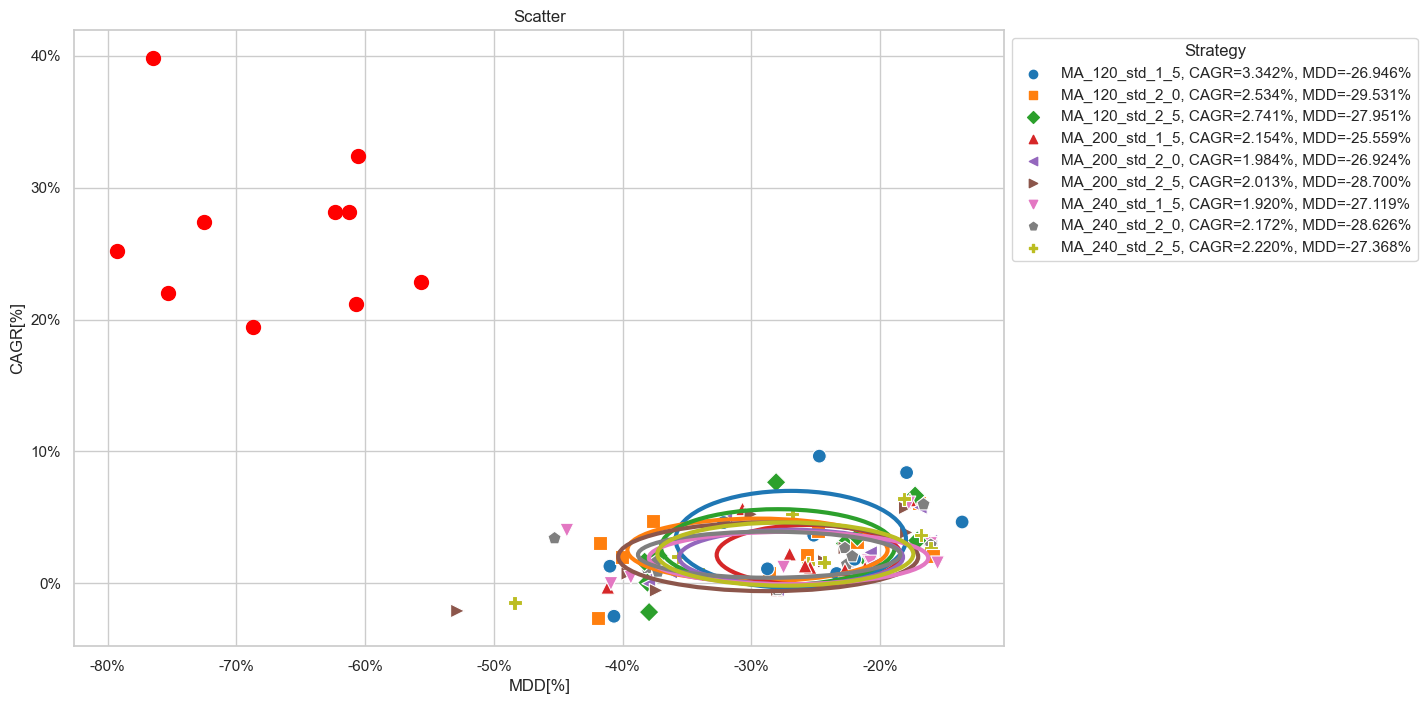

In [17]:
# D
draw_strategy_scatter(p_bband_df,sector_top_5_df)

In [ ]:
draw_strategy_kde(p_bband_df)

# 逢低買進
同時考量價格與成交量的乖離，當收盤價跌破移動平均線且乖離超過設定比例，成交量突破平均成交量且乖離超過設定比例觸發進場條件，持有到窗格最後一天，可設定的參數為移動平均線、均線乖離、平均成交量天數、成交量乖離。
1. 移動平均線 : 20、40、60日，搭配10%均線乖離
2. 成交量 : 5日平均成交量，搭配50%及80%成交量乖離

In [11]:
close = data.get('price:close')
vol = data.get('price:volume')
vol.index = pd.to_datetime(vol.index)

buy_at_low_conditions={}

for sector in sector_top_5_df['factor']:
    for price_ma in [20,40,60,80,100]:
        for vol_dev in [0.4, 0.5, 0.6,0.7,0.8]:
            # 價格ma
            p_ma = close.average(price_ma)
            # 價格dev
            p_dev = (close - p_ma) / p_ma
            # 成交量ma
            v_ma = vol.average(5)
            # 成交量dev
            v_dev = (vol - v_ma) / v_ma
            entries = (close <= p_ma) & (abs(p_dev) >= 0.1) & (vol >= v_ma) & (abs(v_dev) >= vol_dev)
            exits = entries.resample('M').last()
            strategy = entries.hold_until(exits)

            buy_at_low_conditions[f'p_{price_ma}_0.1_v_5_{vol_dev}&{sector}'.replace('.', '_')] = strategy & results_dict[str(sector)]
        

In [ ]:
close = data.get('price:close')
vol = data.get('price:volume')
vol.index = pd.to_datetime(vol.index)

buy_at_low_conditions={}

for factor in factor_dict.keys():
    for price_ma in [20,40,60]:
        for vol_dev in [0.5, 0.8]:
            # 價格ma
            p_ma = close.average(price_ma)
            # 價格dev
            p_dev = (close - p_ma) / p_ma
            # 成交量ma
            v_ma = vol.average(5)
            # 成交量dev
            v_dev = (vol - v_ma) / v_ma
            entries = (close <= p_ma) & (p_dev >= 0.1) & (vol >= v_ma) & (v_dev >= vol_dev)
            exits = entries.resample('M').last()
            strategy = entries.hold_until(exits)

            buy_at_low_conditions[f'p_{price_ma}_0.1_v_5_{vol_dev}&{factor}'.replace('.', '_')] = strategy & factor_dict[str(factor)]
        

In [12]:
buy_at_low_report_collection = sim_conditions(conditions=buy_at_low_conditions, resample='M', data=data, combination=False)
buy_at_low_df = buy_at_low_report_collection.stats.T
buy_at_low_df.index = buy_at_low_df.index.str.split('&', n=1, expand=True)
buy_at_low_df = buy_at_low_df.reset_index(names=['strategy', 'factor'])
split_columns = buy_at_low_df['strategy'].str.split('_', expand=True)
buy_at_low_df['MA'] = split_columns[1].astype(int)
buy_at_low_df['std'] = split_columns[6].astype(int) + (split_columns[7].astype(int)/10)

Backtesting progress: 100%|██████████| 250/250 [04:33<00:00,  1.09s/condition]


In [13]:
buy_at_low_df.to_csv('../Data/factor_strategy_result/buy_at_low_df.csv', encoding='utf-8-sig')

In [20]:
buy_at_low_df.sort_values(by=['CAGR'], ascending=False).head(10)

,strategy,factor,CAGR,daily_sharpe,max_drawdown,avg_drawdown,win_ratio,ytd
20,p_40_0_1_v_5_0_5,建材營造&p_ic,0.097834,38.65,-0.347774,-0.091250,0.495575,0.0
18,p_20_0_1_v_5_0_5,建材營造&p_ic,0.088644,44.65,-0.347774,-0.098373,0.489796,0.0
21,p_40_0_1_v_5_0_8,建材營造&p_ic,0.086768,44.90,-0.347774,-0.093315,0.491803,0.0
22,p_60_0_1_v_5_0_5,建材營造&p_ic,0.084826,42.22,-0.348849,-0.100792,0.500000,0.0
19,p_20_0_1_v_5_0_8,建材營造&p_ic,0.080142,46.28,-0.347774,-0.104384,0.487603,0.0
23,p_60_0_1_v_5_0_8,建材營造&p_ic,0.074639,50.15,-0.365311,-0.102816,0.495726,0.0
38,p_40_0_1_v_5_0_5,建材營造&ps,0.067022,45.91,-0.271894,-0.054341,0.491304,0.0
39,p_40_0_1_v_5_0_8,建材營造&ps,0.066555,47.52,-0.271894,-0.060298,0.489960,0.0
41,p_60_0_1_v_5_0_8,建材營造&ps,0.066488,47.44,-0.301219,-0.065415,0.497890,0.0
36,p_20_0_1_v_5_0_5,建材營造&ps,0.065856,47.72,-0.271785,-0.055958,0.483607,0.0


C:\Users\iplab\AppData\Local\Temp\ipykernel_28788\3397861958.py:15: UserWarning: The markers list has more values (9) than needed (6), which may not be intended.
  scatter_plot = sns.scatterplot(x='max_drawdown', y='CAGR', hue='strategy', style='strategy', markers=markers, s=100, data=df, palette='tab10')


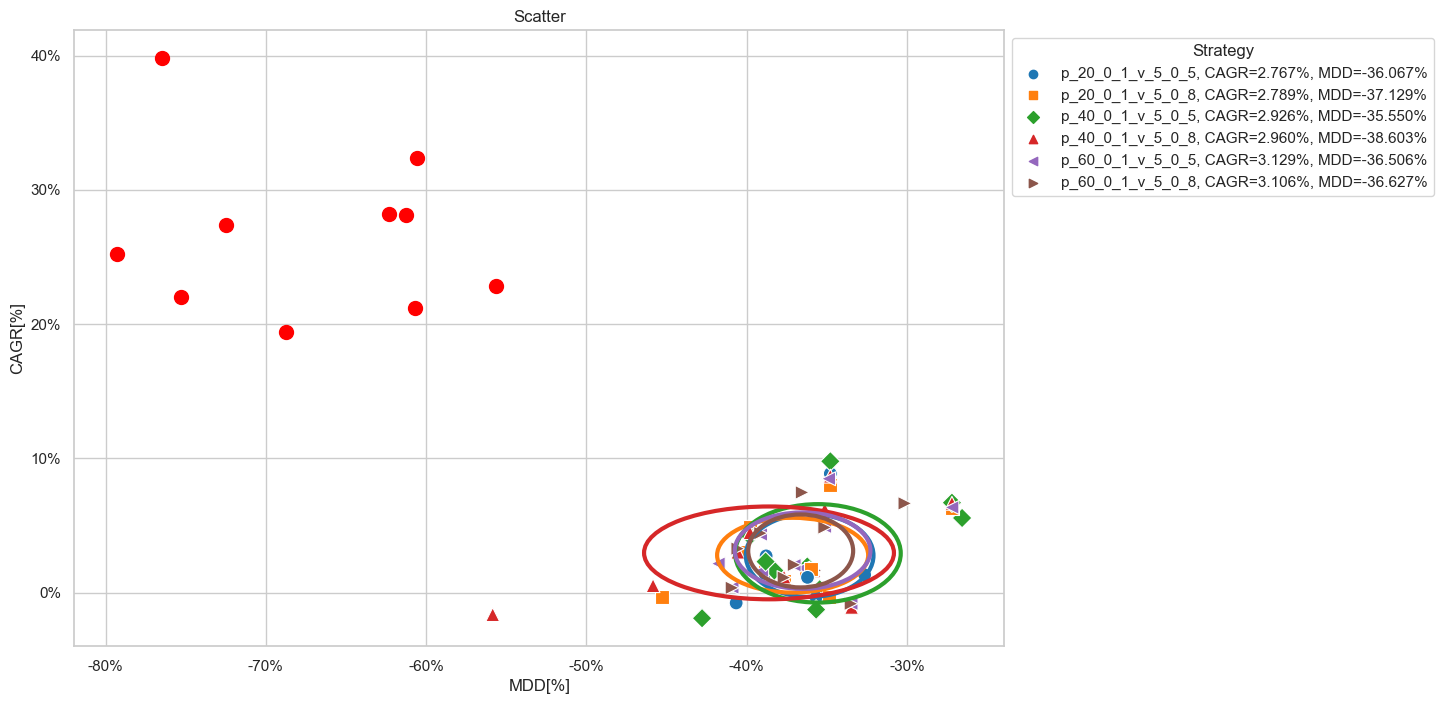

In [21]:
# D
draw_strategy_scatter(buy_at_low_df,sector_top_5_df)

In [ ]:
draw_strategy_kde(buy_at_low_df)

# 逆勢高低通道
當收盤價跌破前數日低點時觸發進場條件，當收盤價突破前數日高點時觸發出場條件，可設定的參數為前數日的天數。
1. 前N日 : 100、120、200、240日

In [45]:
close = data.get('price:close')

hign_low_band_conditions={}

for sector in sector_top_5_df['factor']:
    for ma in [*range(10,400,20)]:
        # 前幾日最低點
        p_min = close.rolling(ma).min()
        # 前幾日最高點
        p_max = close.rolling(ma).max()

        entries = close > p_min
        exits = close < p_max
        strategy = entries.hold_until(exits)
        hign_low_band_conditions[f'ma_{ma}&{sector}'] = strategy &  results_dict[str(sector)]

MemoryError: Unable to allocate 78.0 MiB for an array with shape (1775, 5758) and data type float64

In [ ]:
close = data.get('price:close')

hign_low_band_conditions={}

for factor in factor_dict.keys():
    for ma in [100,120,200,140]:
        # 前幾日最低點
        p_min = close.rolling(ma).min()
        # 前幾日最高點
        p_max = close.rolling(ma).max()

        entries = close > p_min
        exits = close < p_max
        strategy = entries.hold_until(exits)
        hign_low_band_conditions[f'ma_{ma}&{factor}'] = strategy & factor_dict[str(factor)]

In [ ]:
hign_low_band_report_collection = sim_conditions(conditions=hign_low_band_conditions, resample='Q', data=data, combination=False)
hign_low_band_df = hign_low_band_report_collection.stats.T
hign_low_band_df.index = hign_low_band_df.index.str.split('&', n=1, expand=True)
hign_low_band_df = hign_low_band_df.reset_index(names=['strategy', 'factor'])
split_columns = hign_low_band_df['strategy'].str.split('_', expand=True)
hign_low_band_df['MA'] = split_columns[1].astype(int)

Backtesting progress: 100%|██████████| 40/40 [00:35<00:00,  1.14condition/s]


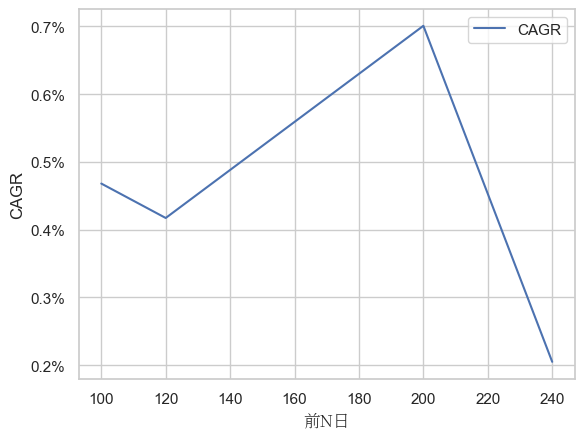

In [ ]:
from matplotlib.ticker import FuncFormatter
from matplotlib.font_manager import FontProperties
ax = hign_low_band_df[['MA','CAGR']].groupby(['MA']).mean().reset_index().plot(x='MA', y='CAGR')

font = FontProperties(fname=r'NotoSerifTC-Light.otf')
plt.xlabel('前N日', fontproperties=font)
plt.ylabel('CAGR')

formatter = FuncFormatter(lambda x, _: '{:.1%}'.format(x))
ax.yaxis.set_major_formatter(formatter)

In [26]:
hign_low_band_df.sort_values(by=['CAGR'], ascending=False).head(5)

,strategy,factor,CAGR,daily_sharpe,max_drawdown,avg_drawdown,win_ratio,ytd,MA
37,ma_120,半導體&ps,0.091758,33.54,-0.343130,-0.193412,0.700000,0.0,120
36,ma_100,半導體&ps,0.091758,33.54,-0.343130,-0.193412,0.700000,0.0,100
39,ma_240,半導體&ps,0.080983,36.57,-0.399742,-0.194821,0.714286,0.0,240
38,ma_200,半導體&ps,0.080983,36.57,-0.399742,-0.194821,0.714286,0.0,200
28,ma_100,半導體&p_ic,0.040739,108.54,-0.355172,-0.119005,0.666667,0.0,100


C:\Users\iplab\AppData\Local\Temp\ipykernel_19104\3397861958.py:15: UserWarning: The markers list has more values (9) than needed (4), which may not be intended.
  scatter_plot = sns.scatterplot(x='max_drawdown', y='CAGR', hue='strategy', style='strategy', markers=markers, s=100, data=df, palette='tab10')


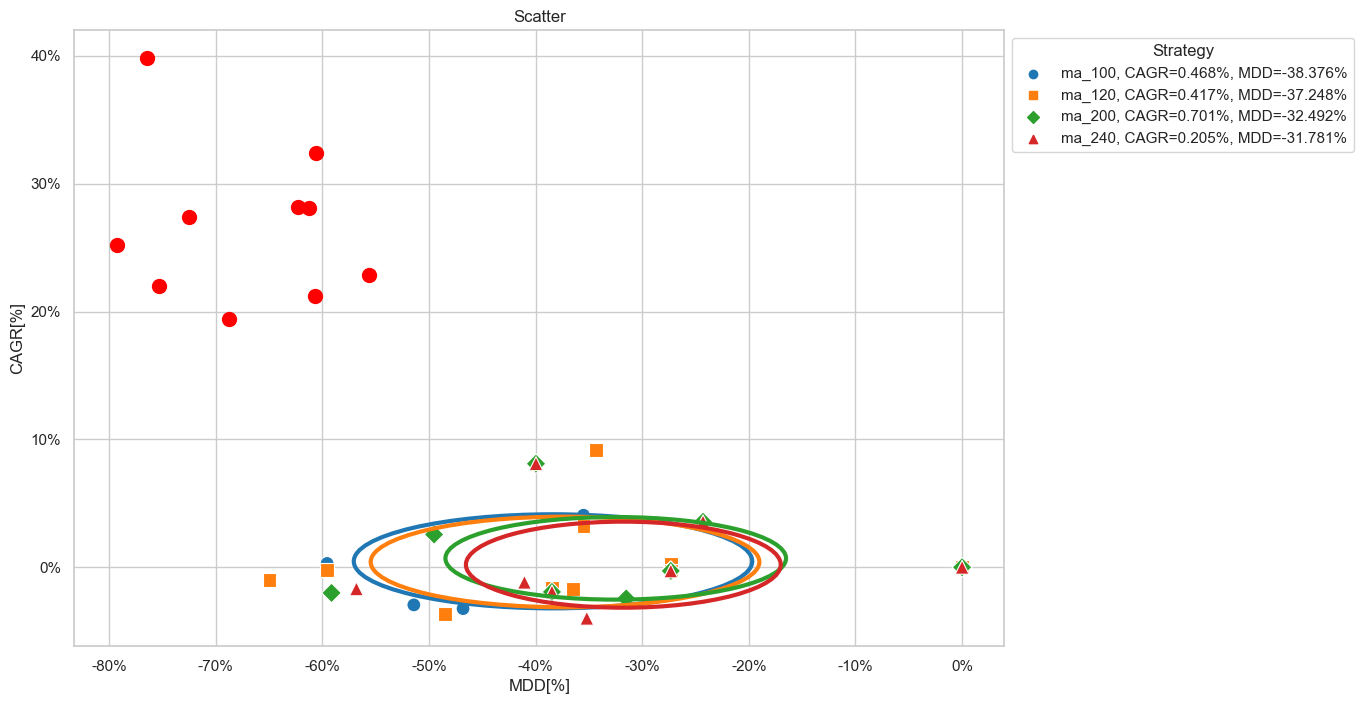

In [22]:
# D
draw_strategy_scatter(hign_low_band_df,sector_top_5_df)

In [ ]:
draw_strategy_kde(hign_low_band_df)